# DS Master Class - predykcja odejścia klientów (`churn`) 


## Biblioteki i dane

In [47]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
import catboost as ctb
from tqdm import tqdm
import xgboost as xgb 
np.random.seed(0)

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import fbeta_score, precision_score, recall_score
import eli5

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [48]:
models = [
    DecisionTreeClassifier(max_depth=7),
    RandomForestClassifier(max_depth=7, n_estimators=100, random_state=0),
    ExtraTreesClassifier(max_depth=7, n_estimators=100, random_state=0),
    xgb.XGBClassifier(max_depth=7, n_estimators=100, random_state=0, learning_rate=0.3),
    ctb.CatBoostClassifier(max_depth=7, n_estimators=200, random_state=0, learning_rate=0.085, verbose=False)
]

In [49]:
df_train = pd.read_hdf("../input/train_churn_pred.h5")
df_test = pd.read_hdf("../input/test_churn_pred.h5")
df_train.shape, df_test.shape

((34999, 171), (35000, 170))

# Połączenie zbiorów

In [50]:
df_all = pd.concat([df_train, df_test]).reset_index(drop=True)

df_train.shape, df_test.shape, df_all.shape

((34999, 171), (35000, 170), (69999, 171))

In [51]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Columns: 171 entries, id to churn_probability
dtypes: float16(33), float32(102), float64(1), int16(10), int32(3), int64(1), int8(15), object(6)
memory usage: 39.1+ MB


In [52]:
df_all.describe()

,id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
count,69999.000000,69297.0,69297.0,69297.0,69999.0,69999.0,69999.0,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.0,67312.0,66296.0,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.0,67312.0,66296.0,67231.000000,67312.000000,66296.000000,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,17568.000000,17865.000000,18417.000000,17568.0,17865.0,18417.0,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,17568.0,17865

In [53]:
df_all.sample(5)

,id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
38105,6280,0.0,0.0,0.0,30,31,31,323.257996,188.007996,194.110001,96.510002,48.279999,68.680000,202.679993,123.6875,110.860001,0.0,0.0,0.00,0.0,0.0,0.0,96.510002,48.279999,68.680000,201.380005,114.360001,104.790001,1.29,0.160000,6.060000,0.00,0.00,0.000000,299.190002,162.809998,179.500000,0.00,0.000000,0.000000,0.00,9.100000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,9.100000,0.00000,0.0,0.0,0.0,0.060000,0.06,0.00,0.0,0.0,0.0,299.260010,171.979996,179.539993,19.090000,6.890000,6.130000,937.489990,754.710022,531.880005,0.150000,0.209961,5.140000,956.739990,761.830017,543.159973,0.00,0.00,0.00,0.000000,3.51,0.000000,0.00,0.00,0.0,0.0,0.0,0.0,0.00,3.51,0.000000,956.739990,765.340027,543.159973,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,14,11,8,390,220,210,30,30,50,6/30/2014,7/31/2014,8/31/2014,30,30,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,677,0.000000,0.00000,0.000000,NaN
32967,65915,0.0,0.0,0.0,30,31,31,638.008972,920.471985,702.440002,144.059998,105.940002,139.690002,484.190002,623.0000,449.309998,0.0,0.0,0.00,0.0,0.0,0.0,130.139999,104.540001,138.039993,431.029999,555.659973,379.540009,18.41,67.480003,53.580002,0.00,0.00,2.500000,579.590027,727.690002,571.000000,13.91,1.400000,1.650000,0.00,0.000000,2.80,0.0,0.0,0.1,0.0,0.0,0.0,13.91,1.400000,4.55000,0.0,0.0,0.0,34.740002,0.00,13.28,0.0,0.0,0.0,

# Feature engineering
Logarytmizacja wszystkich cech numerycznych, black list

In [54]:
black_list = ["id", "churn_probability"]
shift = 100
num_feats = [x for x in df_all.select_dtypes("number").columns if x not in black_list]

num_feats_log=[]
for num_feat in num_feats:
    num_feat_log_idx = '{0}_log'.format(num_feat)
    df_all[num_feat_log_idx]= np.log(df_all[num_feat]+shift)
    num_feats_log.append(num_feat_log_idx)


/opt/conda/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


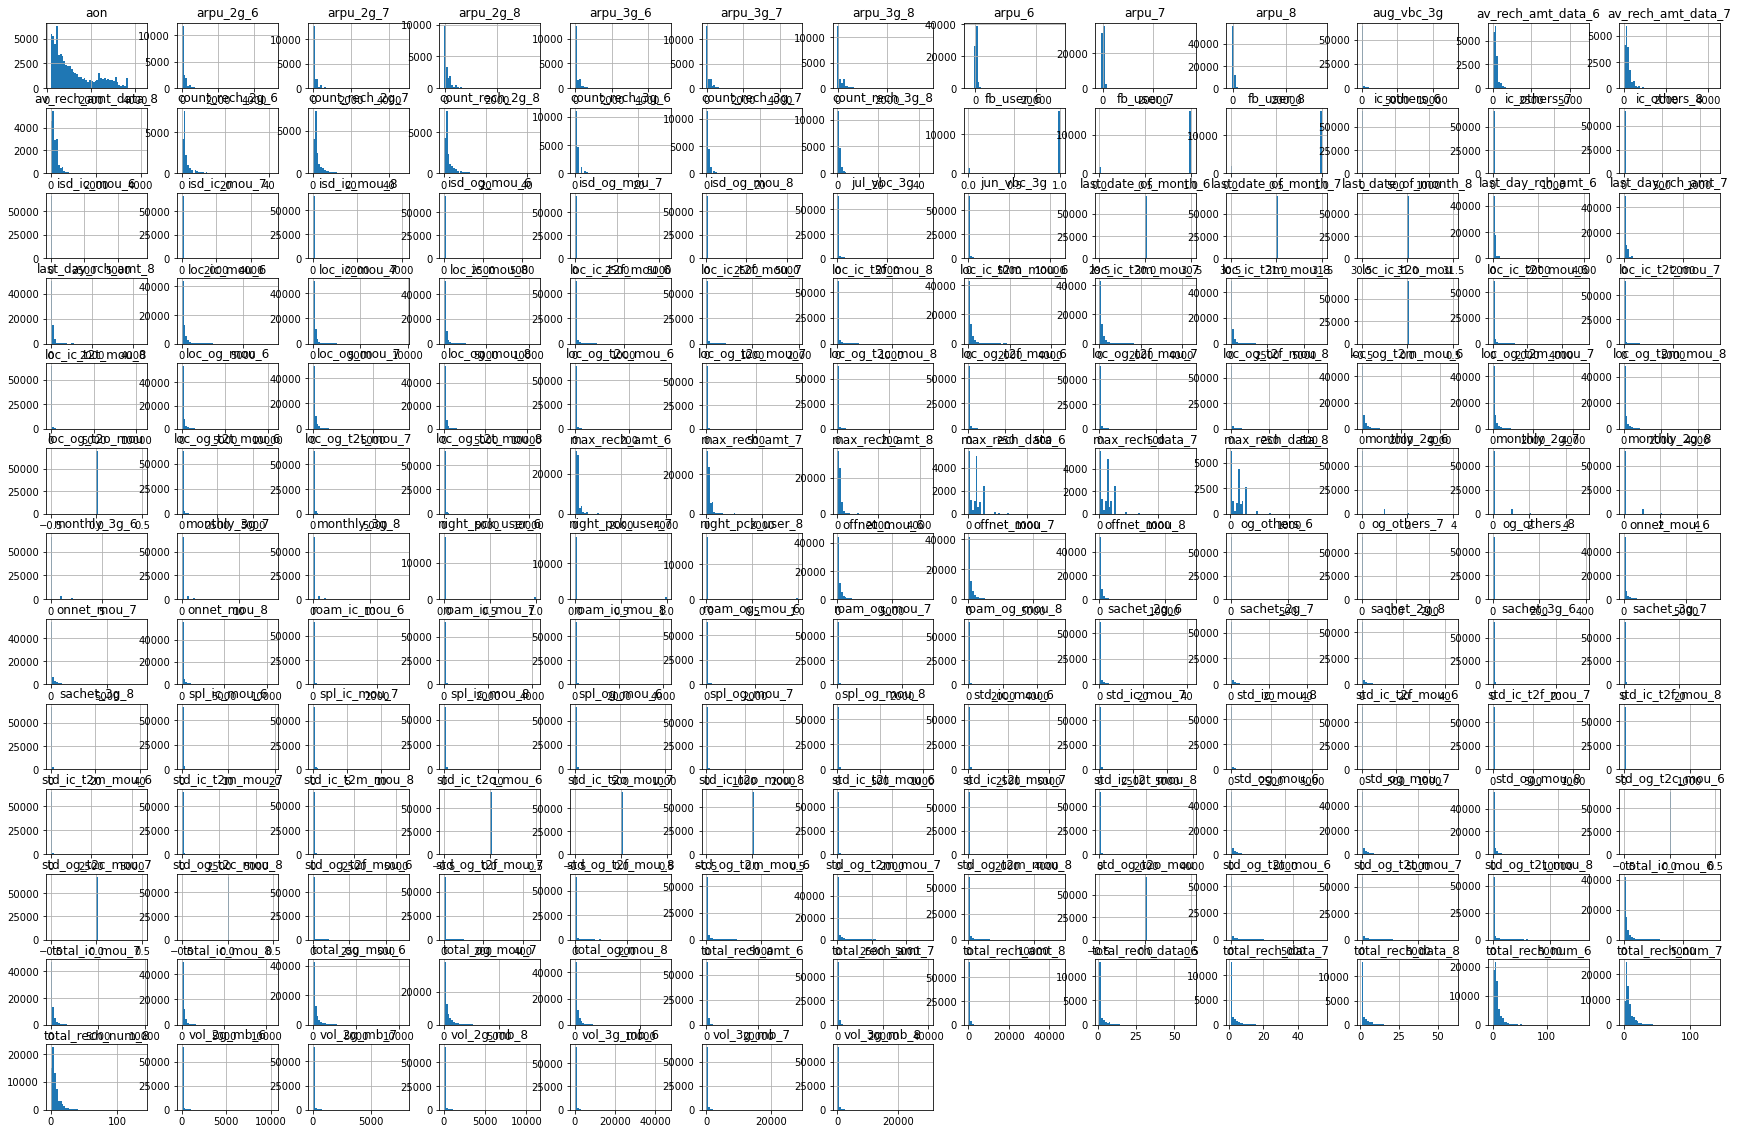

In [55]:
df_all[num_feats].hist(figsize=(30,20), bins=50);


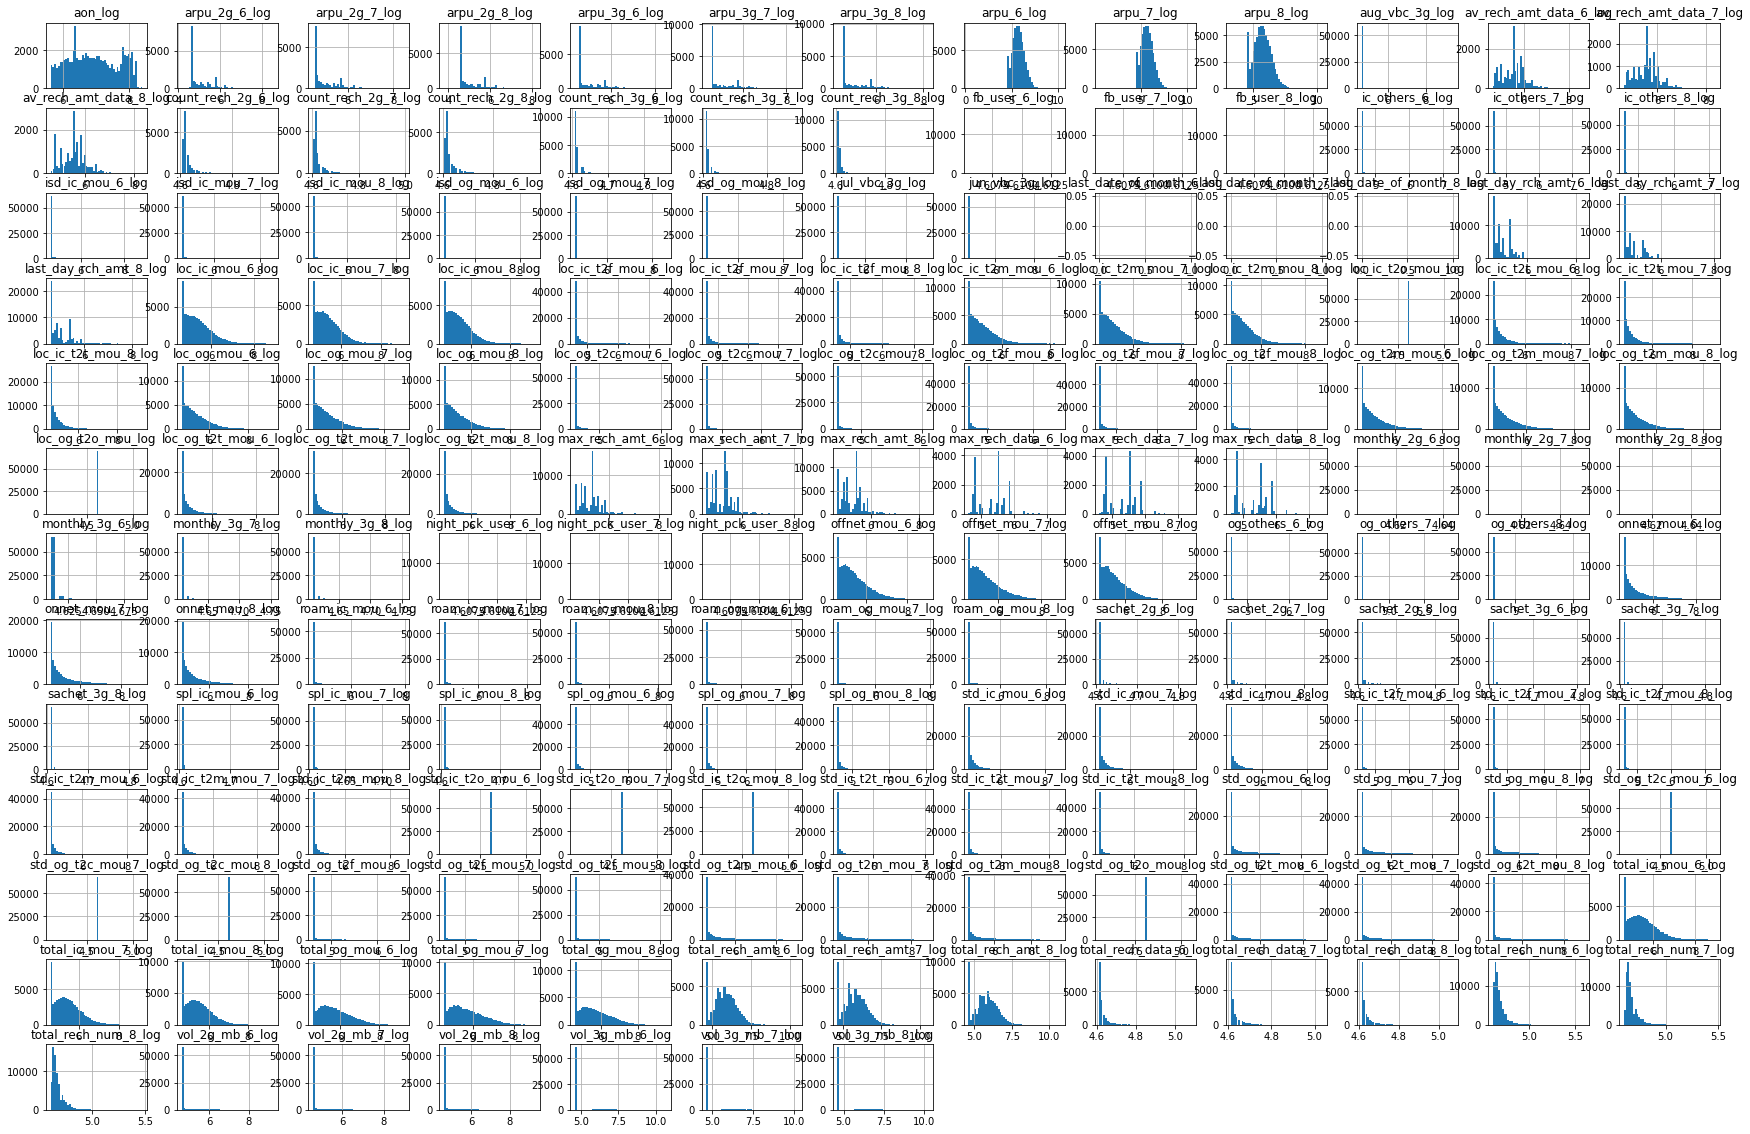

In [56]:
df_all[num_feats_log].hist(figsize=(30,20), bins=50);

Odejmowanie cech

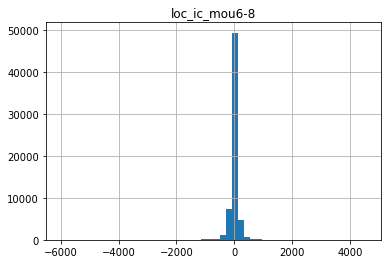

In [57]:
minus_numbers = [(6, 8)]

minus_feats_loc_ic_mou = []
for x, y in minus_numbers:
    output_idx = 'loc_ic_mou{0}-{1}'.format(x, y)
    df_all[output_idx] = df_all['loc_ic_mou_{0}'.format(x)] - df_all['loc_ic_mou_{0}'.format(y)]
    minus_feats_loc_ic_mou.append(output_idx)
                                                                     
    df_all[output_idx].hist(bins=50);
    plt.title(output_idx)
    plt.show()

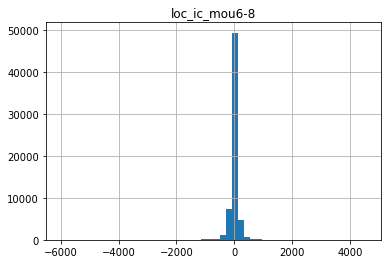

In [58]:
minus_numbers = [(6, 8)]

minus_feats_loc_ic_mou = []
for x, y in minus_numbers:
    output_idx = 'loc_ic_mou{0}-{1}'.format(x, y)
    df_all[output_idx] = df_all['loc_ic_mou_{0}'.format(x)] - df_all['loc_ic_mou_{0}'.format(y)]
    minus_feats_loc_ic_mou.append(output_idx)
                                                                     
    df_all[output_idx].hist(bins=50);
    plt.title(output_idx)
    plt.show()

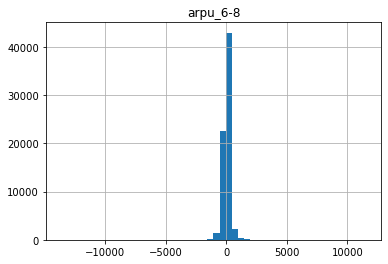

In [59]:
minus_numbers = [(6, 8)]

minus_feats_arpu = []
for x, y in minus_numbers:
    output_idx = 'arpu_{0}-{1}'.format(x, y)
    df_all[output_idx] = df_all['arpu_{0}'.format(x)] - df_all['arpu_{0}'.format(y)]
    minus_feats_arpu.append(output_idx)
                                                                     
    df_all[output_idx].hist(bins=50);
    plt.title(output_idx)
    plt.show()

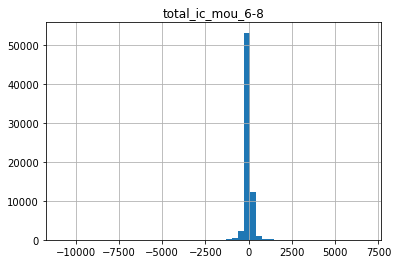

In [60]:
minus_numbers = [(6, 8)]

minus_total_ic_mou = []
for x, y in minus_numbers:
    output_idx = 'total_ic_mou_{0}-{1}'.format(x, y)
    df_all[output_idx] = df_all['total_ic_mou_{0}'.format(x)] - df_all['total_ic_mou_{0}'.format(y)]
    minus_total_ic_mou.append(output_idx)
                                                                     
    df_all[output_idx].hist(bins=50);
    plt.title(output_idx)
    plt.show()

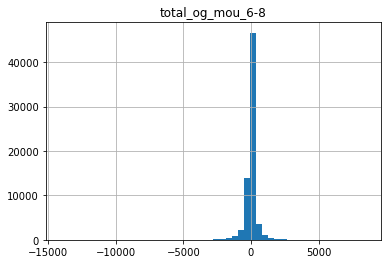

In [61]:
minus_numbers = [(6, 8)]

minus_total_og_mou = []
for x, y in minus_numbers:
    output_idx = 'total_og_mou_{0}-{1}'.format(x, y)
    df_all[output_idx] = df_all['total_og_mou_{0}'.format(x)] - df_all['total_og_mou_{0}'.format(y)]
    minus_total_og_mou.append(output_idx)
                                                                     
    df_all[output_idx].hist(bins=50);
    plt.title(output_idx)
    plt.show()

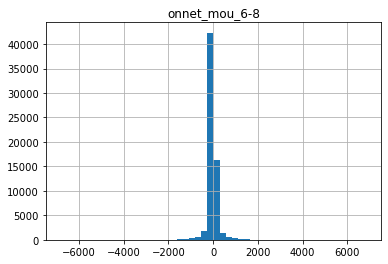

In [62]:
minus_numbers = [(6, 8)]

minus_onnet_mou = []
for x, y in minus_numbers:
    output_idx = 'onnet_mou_{0}-{1}'.format(x, y)
    df_all[output_idx] = df_all['onnet_mou_{0}'.format(x)] - df_all['onnet_mou_{0}'.format(y)]
    minus_onnet_mou.append(output_idx)
                                                                     
    df_all[output_idx].hist(bins=50);
    plt.title(output_idx)
    plt.show()

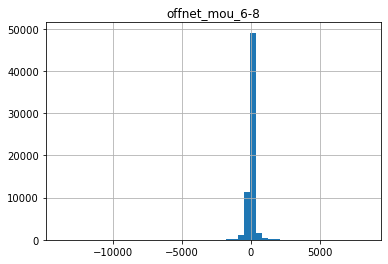

In [63]:
minus_numbers = [(6, 8)]

minus_offnet_mou = []
for x, y in minus_numbers:
    output_idx = 'offnet_mou_{0}-{1}'.format(x, y)
    df_all[output_idx] = df_all['offnet_mou_{0}'.format(x)] - df_all['offnet_mou_{0}'.format(y)]
    minus_offnet_mou.append(output_idx)
                                                                     
    df_all[output_idx].hist(bins=50);
    plt.title(output_idx)
    plt.show()

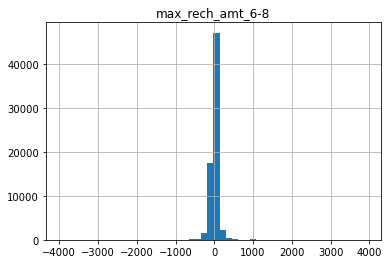

In [64]:
minus_numbers = [(6, 8)]

minus_max_rech_amt = []
for x, y in minus_numbers:
    output_idx = 'max_rech_amt_{0}-{1}'.format(x, y)
    df_all[output_idx] = df_all['max_rech_amt_{0}'.format(x)] - df_all['max_rech_amt_{0}'.format(y)]
    minus_max_rech_amt.append(output_idx)
                                                                     
    df_all[output_idx].hist(bins=50);
    plt.title(output_idx)
    plt.show()

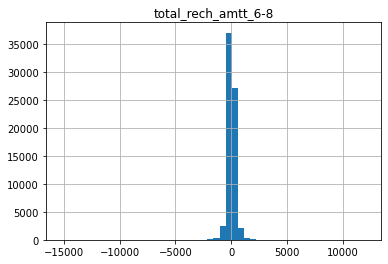

In [65]:
minus_numbers = [(6, 8)]

minus_total_rech_amt = []
for x, y in minus_numbers:
    output_idx = 'total_rech_amtt_{0}-{1}'.format(x, y)
    df_all[output_idx] = df_all['total_rech_amt_{0}'.format(x)] - df_all['total_rech_amt_{0}'.format(y)]
    minus_total_rech_amt.append(output_idx)
                                                                     
    df_all[output_idx].hist(bins=50);
    plt.title(output_idx)
    plt.show()

Normalizacja cech numerycznych

In [66]:
num_feats_for_norm = num_feats
[(feat, df_all[feat].skew()) for feat in num_feats_for_norm]

[('loc_og_t2o_mou', 0),
 ('std_og_t2o_mou', 0),
 ('loc_ic_t2o_mou', 0),
 ('last_date_of_month_6', 0),
 ('last_date_of_month_7', 0),
 ('last_date_of_month_8', 0),
 ('arpu_6', 13.700342),
 ('arpu_7', 20.271334),
 ('arpu_8', 19.045774),
 ('onnet_mou_6', 6.14053),
 ('onnet_mou_7', 6.593318),
 ('onnet_mou_8', 7.149101),
 ('offnet_mou_6', 4.933533),
 ('offnet_mou_7', nan),
 ('offnet_mou_8', 6.1842103),
 ('roam_ic_mou_6', 16.844322),
 ('roam_ic_mou_7', 27.373081),
 ('roam_ic_mou_8', 25.776789),
 ('roam_og_mou_6', 14.083543),
 ('roam_og_mou_7', 14.273038),
 ('roam_og_mou_8', 23.746729),
 ('loc_og_t2t_mou_6', 13.9332485),
 ('loc_og_t2t_mou_7', 15.3907175),
 ('loc_og_t2t_mou_8', 19.932182),
 ('loc_og_t2m_mou_6', 6.0267262),
 ('loc_og_t2m_mou_7', 5.318859),
 ('loc_og_t2m_mou_8', 5.4744487),
 ('loc_og_t2f_mou_6', 12.934191),
 ('loc_og_t2f_mou_7', 13.777206),
 ('loc_og_t2f_mou_8', 12.678154),
 ('loc_og_t2c_mou_6', 22.473856),
 ('loc_og_t2c_mou_7', 42.566673),
 ('loc_og_t2c_mou_8', 17.205656),
 ('lo

In [67]:
from sklearn.preprocessing import minmax_scale

for feat in tqdm(num_feats_for_norm):
    if (df_all[feat].skew() > 0.5 or df_all[feat].skew() < -0.5) : continue
    df_all[feat + '_sqrt'] = np.sqrt( minmax_scale(df_all[feat]) )
 
    
sqrt_num_feats = [feat for feat in df_all if 'sqrt' in feat]   
    

100%|██████████| 163/163 [00:00<00:00, 241.30it/s]


In [68]:
sqrt_num_feats

['loc_og_t2o_mou_sqrt',
 'std_og_t2o_mou_sqrt',
 'loc_ic_t2o_mou_sqrt',
 'last_date_of_month_6_sqrt',
 'last_date_of_month_7_sqrt',
 'last_date_of_month_8_sqrt',
 'offnet_mou_7_sqrt',
 'loc_og_mou_8_sqrt',
 'std_og_t2c_mou_6_sqrt',
 'std_og_t2c_mou_7_sqrt',
 'std_og_t2c_mou_8_sqrt',
 'loc_ic_t2f_mou_7_sqrt',
 'std_ic_t2o_mou_6_sqrt',
 'std_ic_t2o_mou_7_sqrt',
 'std_ic_t2o_mou_8_sqrt',
 'max_rech_data_6_sqrt',
 'max_rech_data_7_sqrt',
 'max_rech_data_8_sqrt',
 'av_rech_amt_data_6_sqrt',
 'av_rech_amt_data_8_sqrt',
 'vol_3g_mb_7_sqrt']

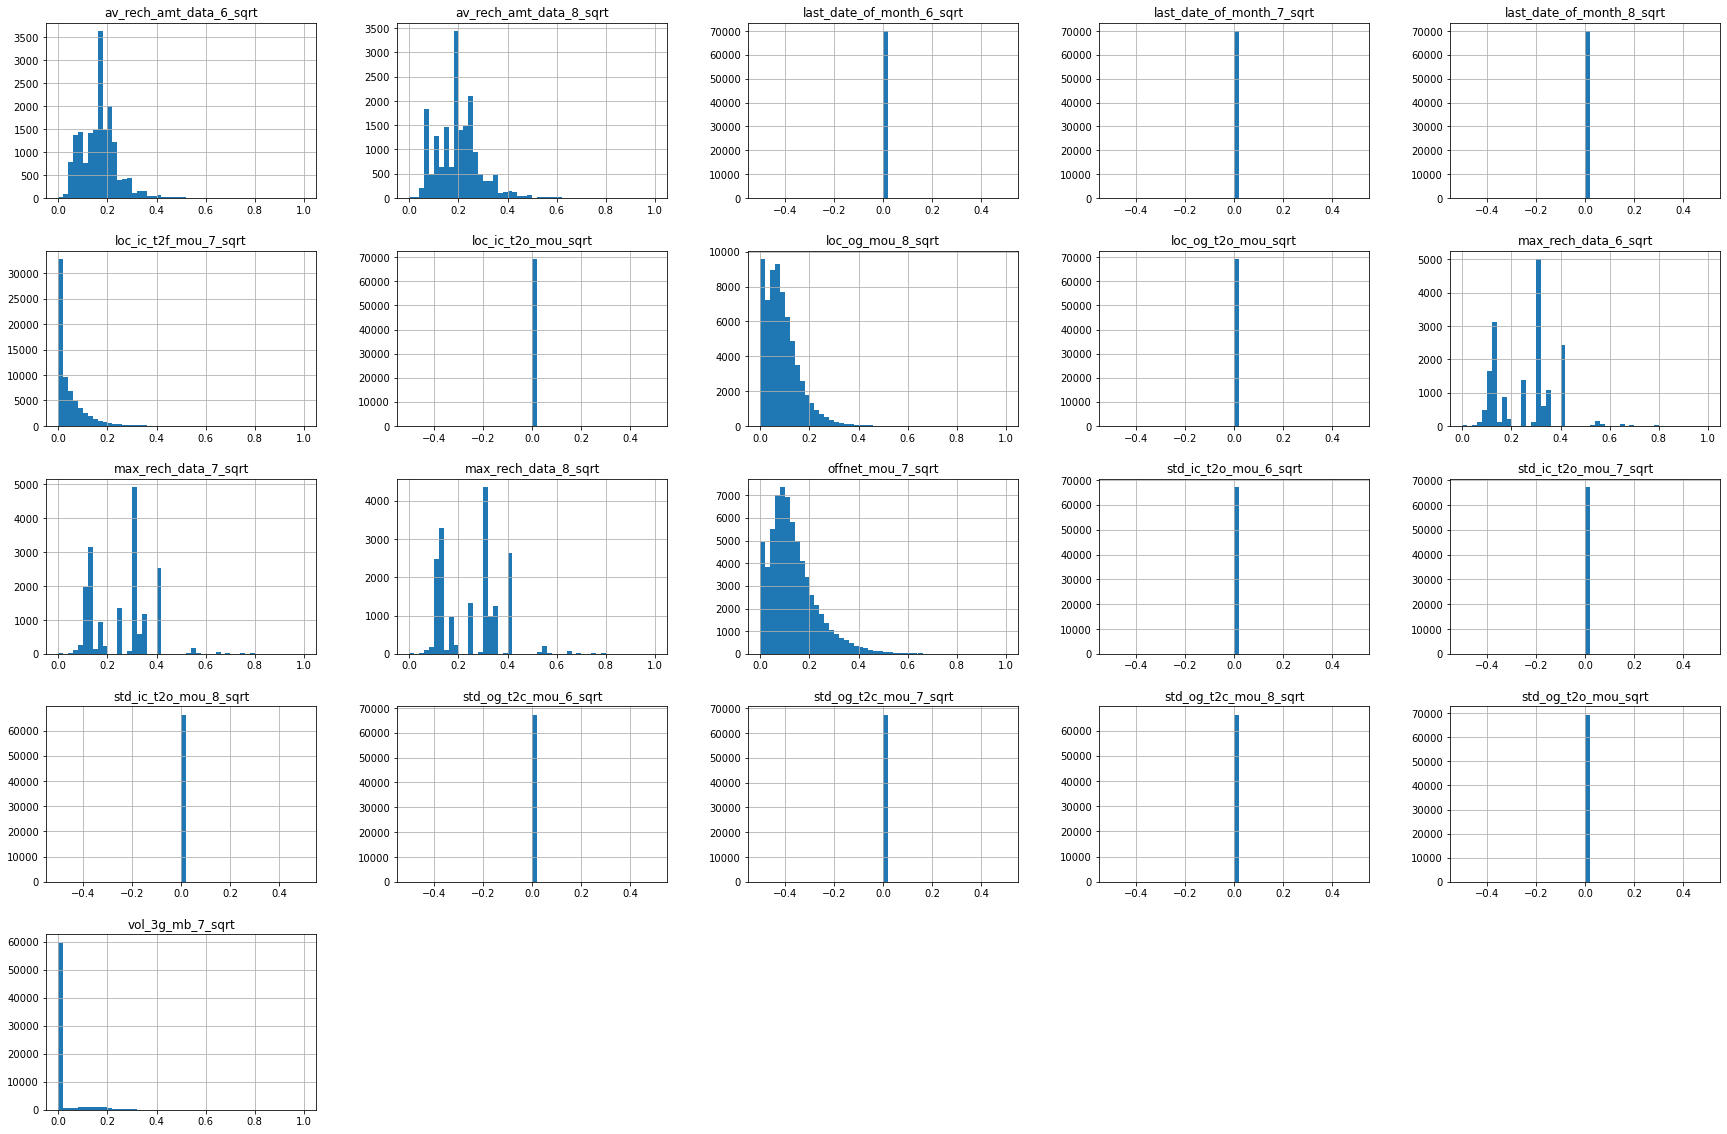

In [69]:
df_all[sqrt_num_feats].hist(figsize=(30,20), bins=50);

Wybór cech do modelu

In [70]:
feats = num_feats+num_feats_log + minus_feats_loc_ic_mou + minus_feats_arpu+ minus_total_ic_mou + minus_total_og_mou + minus_onnet_mou + minus_offnet_mou + minus_max_rech_amt + minus_total_rech_amt +sqrt_num_feats  


In [71]:
feats

['loc_og_t2o_mou',
 'std_og_t2o_mou',
 'loc_ic_t2o_mou',
 'last_date_of_month_6',
 'last_date_of_month_7',
 'last_date_of_month_8',
 'arpu_6',
 'arpu_7',
 'arpu_8',
 'onnet_mou_6',
 'onnet_mou_7',
 'onnet_mou_8',
 'offnet_mou_6',
 'offnet_mou_7',
 'offnet_mou_8',
 'roam_ic_mou_6',
 'roam_ic_mou_7',
 'roam_ic_mou_8',
 'roam_og_mou_6',
 'roam_og_mou_7',
 'roam_og_mou_8',
 'loc_og_t2t_mou_6',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'loc_og_t2m_mou_6',
 'loc_og_t2m_mou_7',
 'loc_og_t2m_mou_8',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_6',
 'std_og_t2m_mou_7',
 'std_og_t2m_mou_8',
 'std_og_t2f_mou_6',
 'std_og_t2f_mou_7',
 'std_og_t2f_mou_8',
 'std_og_t2c_mou_6',
 'std_og_t2c_mou_7',
 'std_og_t2c_mou_8',
 'std_og_mou_6',
 'std_og_mou_7',
 'std_og_mou_8',
 'isd_og_mou_6',
 'isd

# Rozdzielenie zbioru na train i test

In [72]:
df_train = df_all[ df_all["churn_probability"].notnull() ].copy() #rozróżnienie zbiorów train, to ten co posiada odpowiedzi dla target
df_test = df_all[ df_all["churn_probability"].isnull() ].copy() #czy tutaj dodawć copy ?
df_train.shape, df_test.shape

((34999, 363), (35000, 363))

# Trenowanie zbioru

In [73]:
X_train = df_train[feats].fillna(-1).values
y_train = df_train["churn_probability"].values
X_test = df_test[feats].fillna(-1).values

In [74]:
pbar = tqdm(models)
for model in pbar:
    
    model_name = (str(model.__repr__).split("of")[-1].strip()
                  .split("(")[0].split(" ")[0].lower().replace("classifier", "")
                 )
    
    pbar.set_description(str(model_name))
    
    model.fit(X_train, y_train)
    treshold=0.2
    y_pred_proba = model.predict_proba(X_test)[:, 1]#tutaj chodzi o to, ze interesuja nas rozwiazania dla f=1.5
    y_pred = (y_pred_proba > treshold).astype("int")
    
    df_test["churn_probability"] = y_pred

catboost: 100%|██████████| 5/5 [01:34<00:00, 18.99s/it]    


# Walidacja modelu

In [75]:
from sklearn.metrics import make_scorer

fbeta_15 = make_scorer(fbeta_score, beta=1.5)
cv = StratifiedKFold(n_splits=3)


score = cross_val_score(model, X_train, y_train, scoring=fbeta_15, cv=cv, n_jobs=-1).mean()
score

0.6518770013059535

# Zapis modelu na dysk

In [76]:
df_test["churn_probability"]=df_test["churn_probability"].astype(bool) 

In [77]:
df_test[ ["id", "churn_probability"] ].to_csv("../output/{}_simple17.csv".format(model_name), index=False)

In [78]:
df_test[ ["id", "churn_probability"] ]

,id,churn_probability
34999,0,False
35000,1,False
35001,2,False
35002,4,False
35003,5,True
...,...,...
69994,69990,False
69995,69991,False
69996,69992,False
69997,69995,True


# Feature importance

In [79]:
model.fit(X_train, y_train)
eli5.show_weights(model, feature_names=feats, top=100)

Weight,Feature
0.0744,total_ic_mou_8_log
0.0318,last_day_rch_amt_8
0.0313,last_day_rch_amt_8_log
0.0310,roam_og_mou_8
0.0289,spl_ic_mou_8
0.0230,roam_ic_mou_8_log
0.0229,loc_ic_mou_8
0.0204,roam_og_mou_8_log
0.0203,loc_ic_mou_8_log
0.0162,aon_log
